<a href="https://colab.research.google.com/github/Ranimyassaf/NewCode/blob/main/Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 489kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.40MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.97MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/50] Loss D: 0.7563, Loss G: 1.8968


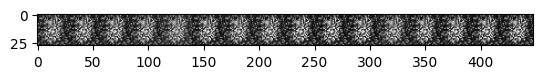

Epoch [2/50] Loss D: 0.2586, Loss G: 3.4350


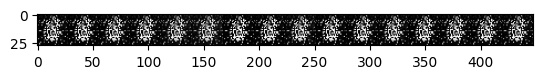

Epoch [3/50] Loss D: 0.4057, Loss G: 3.0504


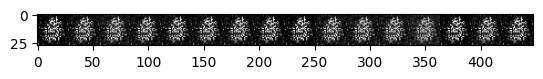

Epoch [4/50] Loss D: 1.2777, Loss G: 1.2092


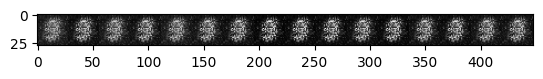

Epoch [5/50] Loss D: 1.4855, Loss G: 1.4694


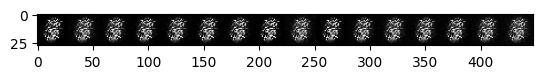

Epoch [6/50] Loss D: 1.5562, Loss G: 0.9820


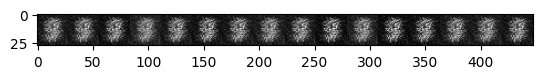

Epoch [7/50] Loss D: 0.7785, Loss G: 2.0194


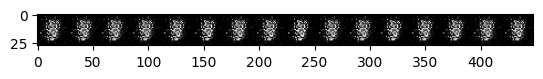

Epoch [8/50] Loss D: 0.2964, Loss G: 2.6805


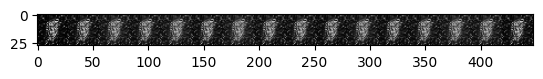

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 128
LATENT_DIM = 100
EPOCHS = 50

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_loader = DataLoader(datasets.MNIST(root='./data', train=True, download=True, transform=transform),
                          batch_size=BATCH_SIZE, shuffle=True)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(LATENT_DIM, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z).view(-1, 1, 28, 28)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

generator = Generator().to(device)
discriminator = Discriminator().to(device)


criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=1e-4)
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4)


for epoch in range(EPOCHS):
    for batch_idx, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        z = torch.randn(batch_size, LATENT_DIM).to(device)
        fake_images = generator(z)
        D_real = discriminator(real_images)
        D_fake = discriminator(fake_images.detach())
        loss_D = criterion(D_real, torch.ones_like(D_real)) + criterion(D_fake, torch.zeros_like(D_fake))
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        D_fake = discriminator(fake_images)
        loss_G = criterion(D_fake, torch.ones_like(D_fake))
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    print(f'Epoch [{epoch+1}/{EPOCHS}] Loss D: {loss_D:.4f}, Loss G: {loss_G:.4f}')

    # Generate sample images
    z = torch.randn(16, LATENT_DIM).to(device)
    fake_images = generator(z).cpu().detach()
    grid = torch.cat([img.squeeze(0) for img in fake_images], dim=1)
    plt.imshow(grid, cmap='gray')
    plt.show()
